In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
from torch.utils.data import DataLoader

from cupbearer import data, detectors, models, scripts, tasks, utils

# Training a backdoored classifier
First, we train a classifier on poisoned data:

In [3]:
train_data = data.MNIST()
val_data = data.MNIST(train=False)

In [4]:
model = models.MLP(input_shape=(28, 28), hidden_dims=[128, 128], output_dim=10)

In [5]:
scripts.train_classifier(
    path=(classifier_path := utils.log_path("logs/demo/classifier")),
    model=model,
    train_loader=DataLoader(
        data.BackdoorDataset(
            # Poison 5% of the training data
            original=train_data,
            backdoor=data.CornerPixelBackdoor(p_backdoor=0.05),
        ),
        batch_size=64,
        shuffle=True,
    ),
    num_classes=10,
    val_loaders={
        "clean": DataLoader(val_data, batch_size=1024, shuffle=False),
        "backdoor": DataLoader(
            data.BackdoorDataset(
                # By default, the poison rate is 100%, so this will let us evaluate
                # performance on completely poisoned data
                original=val_data,
                backdoor=data.CornerPixelBackdoor(),
            ),
            batch_size=1024,
            shuffle=False,
        ),
    },
    max_epochs=3,
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type               | Params
------------------------------------------------------
0 | model          | MLP                | 118 K 
1 | train_accuracy | MulticlassAccuracy | 0     
2 | val_accuracy   | ModuleList         | 0     
3 | test_accuracy  | ModuleList         | 0     
------------------------------------------------------
118 K     Trainable params
0         Non-trainable params
118 K     Total params
0.473     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/erik/.pyenv/versions/3.10.9/envs/cupbearer/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/erik/.pyenv/versions/3.10.9/envs/cupbearer/lib/python3.10/site-packages/torchmetrics/functional/classification/accuracy.py:77: UserWarning: MPS: no support for int64 reduction ops, casting it to int32 (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/ReduceOps.mm:144.)
  tp = tp.sum(dim=0 if multidim_average == "global" else 1)
/Users/erik/.pyenv/versions/3.10.9/envs/cupbearer/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argu

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


{'train/loss': tensor(0.0756),
 'train/acc_step': tensor(0.9688),
 'clean/loss/dataloader_idx_0': tensor(0.1696),
 'clean/acc_step/dataloader_idx_0': tensor(0.9468),
 'backdoor/loss/dataloader_idx_1': tensor(0.1274),
 'backdoor/acc_step/dataloader_idx_1': tensor(0.9580),
 'clean/acc_epoch': tensor(0.9468),
 'backdoor/acc_epoch': tensor(0.9580),
 'train/acc_epoch': tensor(0.9417)}

We can also explicitly evaluate the trained model (right now this is pretty limited and doesn't support multiple datasets at once). In this case it doesn't tell us anything new, but it can be useful if we want to evaluate a model on additional data later:

In [6]:
scripts.eval_classifier(
    data=val_data,
    model=model,
    path=classifier_path,
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/erik/.pyenv/versions/3.10.9/envs/cupbearer/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test/acc_epoch       │    0.9467999935150146     │
│       test/acc_step       │    0.9467999935150146     │
│         test/loss         │    0.16958695650100708    │
└───────────────────────────┴───────────────────────────┘

These results will also have been stored to `<log path>/eval.json` if we want to process them further (e.g. to compare many runs):

In [7]:
with open(classifier_path / "eval.json") as f:
    print(json.load(f))

[{'test/loss': 0.16958695650100708, 'test/acc_step': 0.9467999935150146, 'test/acc_epoch': 0.9467999935150146}]


# Training a backdoor detector
We'll train a very simple detector using the Mahalanobis distance. Our model is still in memory, but just for demonstration let's load it again:

In [8]:
# Initialize a new model with the same architecture as before:
model = models.MLP(input_shape=(28, 28), hidden_dims=[128, 128], output_dim=10)
# Load the weights:
models.load(model, classifier_path)

100%|██████████| 59/59 [00:06<00:00,  9.09it/s]
2024-03-02 18:08:41.589 | INFO     | cupbearer.detectors.anomaly_detector:save_weights:220 - Saving detector to logs/demo/detector/2024-03-02_18-08-34/detector


Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

2024-03-02 18:08:41.947 | INFO     | cupbearer.detectors.anomaly_detector:eval:139 - AUC_ROC: 1.0000
2024-03-02 18:08:41.949 | INFO     | cupbearer.detectors.anomaly_detector:eval:140 - AP: 1.0000


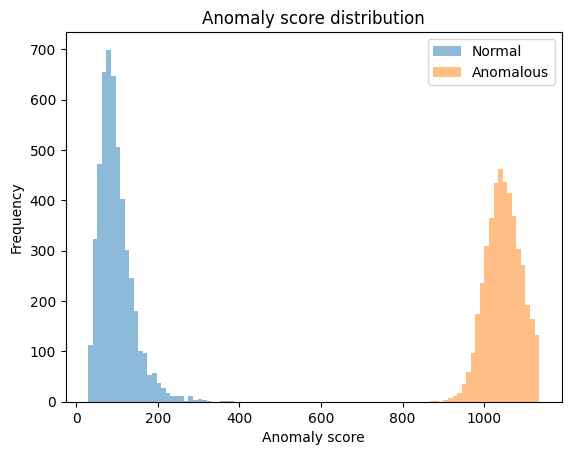

In [9]:
scripts.train_detector(
    save_path=(detector_path := utils.log_path("logs/demo/detector")),
    task=tasks.backdoor_detection(
        model, train_data, val_data, data.CornerPixelBackdoor()
    ),
    detector=detectors.MahalanobisDetector(),
    num_classes=10,
)

As we can see, this was a trivial detection task. As an ablation, we can test whether the detector specifically flags backdoored inputs as anomalous, or just anything out of distribution. Let's again reload the detector just to show how that works:

In [10]:
detector = detectors.MahalanobisDetector()
# TODO: The fact that weights are saved in "detector" is just a convention used by
# the train_detector script, this is kind of weird.
detector.load_weights(detector_path / "detector")

2024-03-02 18:08:42.519 | INFO     | cupbearer.detectors.anomaly_detector:load_weights:224 - Loading detector from logs/demo/detector/2024-03-02_18-08-34/detector


2024-03-02 18:08:43.409 | INFO     | cupbearer.detectors.anomaly_detector:eval:139 - AUC_ROC: 0.9940
2024-03-02 18:08:43.409 | INFO     | cupbearer.detectors.anomaly_detector:eval:140 - AP: 0.9784


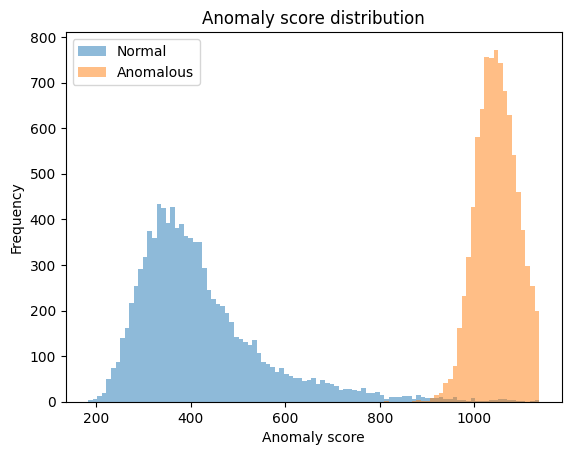

In [11]:
scripts.eval_detector(
    detector=detector,
    # We save to a different directory to avoid overwriting the existing default eval:
    save_path=detector_path / "ood_eval",
    task=tasks.Task.from_separate_data(
        model=model,
        # TODO: this won't actually be used, plausibly Tasks should be split better
        # into their training and test data.
        trusted_data=train_data,
        # Our anomalous data is the backdoor data from above, except we use the
        # MNIST test split.
        anomalous_test_data=data.BackdoorDataset(
            original=val_data,
            backdoor=data.CornerPixelBackdoor(),
        ),
        # Our normal data is MNIST with added noise, this makes the images OOD
        # but they shouldn't be mechanistically anomalous.
        clean_test_data=data.TransformDataset(val_data, data.GaussianNoise(0.3)),
    ),
)

As we can see, adding noise did make the images quite a bit more "anomalous" according to our detector (the blue histogram has shifted to the right to higher anomaly scores). But we still have a very clear separation between these "merely noisy" inputs and the backdoored inputs. (This is a very easy to detect backdoor.)